## Deep Learning with PyTorch : Neural Style Transfer

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

## Loading VGG Pretrained Model

In [ ]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained=True)
print(vgg)

In [ ]:
# no need for classifier part of the model

vgg = vgg.features
print(vgg)

In [3]:
# no need to store gradients for backprop

for parameters in vgg.parameters():
  parameters.requires_grad_(False)
  # print(parameters.shape) # every conv layer has associated W matrix (kxk) and b


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
vgg.to(device)

## Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [6]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size = 500):
  image = Image.open(img_path).convert('RGB')

  if max(image.size) > max_size: # if size is greater than max_size, resize to maxsize
    size = max_size
  else:
    size = max(image.size)

  img_transforms = T.Compose([
      T.Resize(size),
      T.ToTensor(), #(224, 224, 3) -> (3, 224, 224)
      T.Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
  ])

  image = img_transforms(image)

  image = image.unsqueeze(0) # first dimension should be batch size
  # (3, 224, 224) -> (1, 3, 224, 224)

  return image

In [48]:
content_p = preprocess("1690471253952.jpeg")
style_p = preprocess("16e1cea702cf169722364aa427573bb7.jpg")

content_p = content_p.to(device)
style_p = style_p.to(device)

content_p.shape, style_p.shape

(torch.Size([1, 3, 500, 500]), torch.Size([1, 3, 500, 595]))

In [49]:
# Image.open("/content/Project-NST/style12.jpg").size

## Deprocess image

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
    image = tensor.to('cpu').clone()

    image = image.numpy()
    image = image.squeeze(0) #(1, 3, 224, 224) -> (3, 224, 224)
    image = image.transpose(1,2,0) #(3, 224, 224) -> (224, 224, 3)

    image = image*np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = image.clip(0,1)

    return image

In [51]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

content_d.shape, style_d.shape

((500, 500, 3), (500, 595, 3))

C:\Users\mdzai\AppData\Local\Temp\ipykernel_25032\2880119712.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


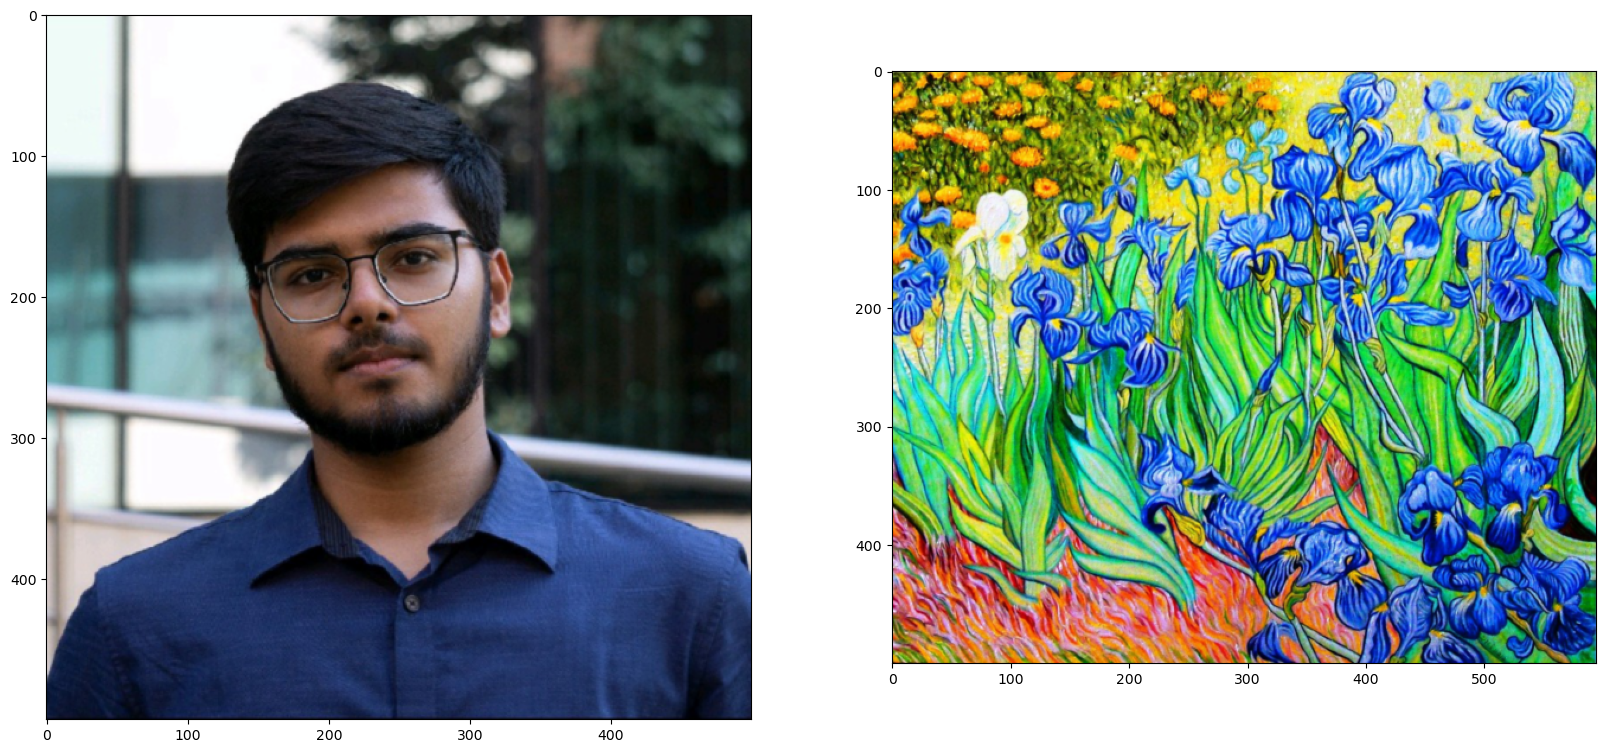

In [52]:
fig, axes = plt.subplots(1,2,figsize=(20,10))

axes[0].imshow(content_d)
axes[1].imshow(style_d)
fig.show()

## Get content,style features and create gram matrix

In [53]:
def get_features(image,model):
  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2', #content_feature
      '28' : 'conv5_1'
  }

  x = image

  features = {}

  for name, layer in model._modules.items():
    x = layer(x) # gives output from forward pass till layer

    if name in layers: # name eg. (0), (5) ..
      features[layers[name]] = x

  return features

In [54]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

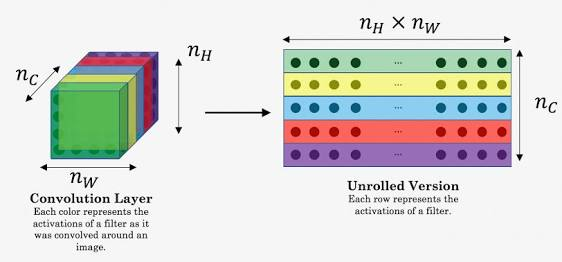

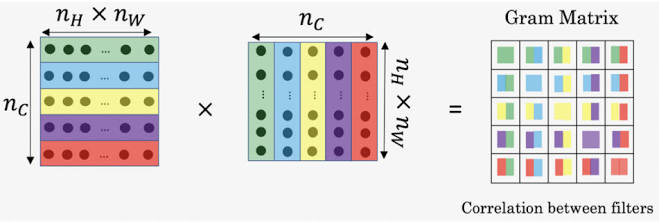

In [55]:
'''So we unroll each layer into a vector and multiply with its transpose
to find the gram matrix which is basically the dot product of pixels in every channel
which gives us the overall corelation between the different channel representation '''

def gram_matrix(tensor):
  b,c,h,w = tensor.size()
  tensor = tensor.view(c, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [56]:
style_grams = {layer : gram_matrix(style_f[layer]) for layer in style_f}
style_grams['conv1_1'].size() # 64 channels
# style_f is a dict containing model outputs

torch.Size([64, 64])

## Creating Style and Content loss function

In [57]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean(target_conv4_2 - content_conv4_2)**2

  return loss

In [58]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

In [59]:
def style_loss(style_weights, target_features, style_grams):
  loss = 0

  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape

    layer_loss = style_weights[layer] * torch.mean((target_gram-style_gram)**2)

    loss += layer_loss/(c*h*w)

  return loss

In [60]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target,vgg)

print("Content Loss: ", content_loss(target_f['conv4_2'], content_f['conv4_2'])) # loss is 0 as target is content clone
print("Style loss: ", style_loss(style_weights, target_f, style_grams))

Content Loss:  tensor(0., device='cuda:0', grad_fn=<PowBackward0>)
Style loss:  tensor(6260.9839, device='cuda:0', grad_fn=<AddBackward0>)


## Training loop

In [66]:
from torch import optim

optimizer = optim.Adam([target], lr=0.001) # pixel values of target are updated

alpha = 1 #content reconstruction weight
beta = 1e5

epochs = 3000
show_every = 500

In [67]:
def total_loss(c_loss, s_loss, alpha, beta):
  loss = alpha * c_loss + beta * s_loss
  return loss

In [71]:
results = []

for i in range(epochs):
  target_f = get_features(target, vgg)
  c_loss = content_loss(target_f['conv4_2'],content_f['conv4_2'])
  s_loss = style_loss(style_weights,target_f,style_grams)
  t_loss = total_loss(c_loss, s_loss, alpha, beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print(f"Total loss at epoch {i}: {t_loss}")
    results.append(deprocess(target.detach()))

Total loss at epoch 0: 59190.765625
Total loss at epoch 500: 50362.78515625
Total loss at epoch 1000: 44252.9453125
Total loss at epoch 1500: 39841.15234375
Total loss at epoch 2000: 36554.9453125
Total loss at epoch 2500: 34013.9375


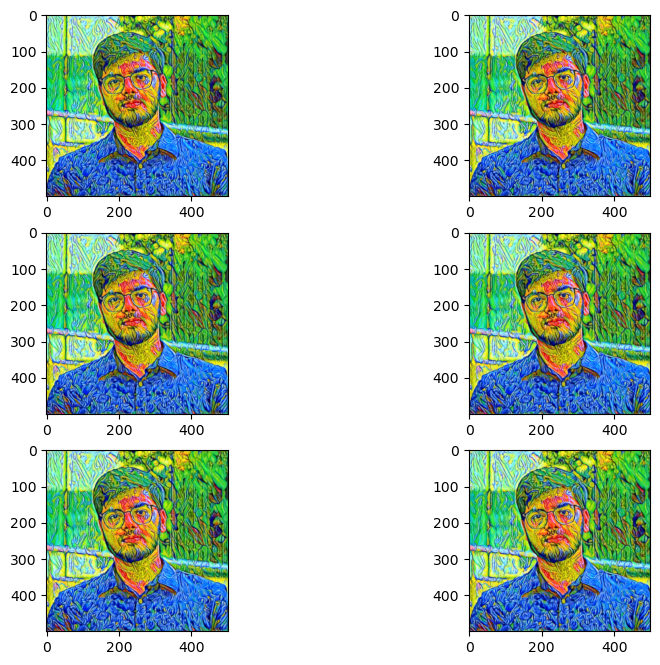

In [74]:
plt.figure(figsize = (10,8))

for i in range(len(results)):
  plt.subplot(3,2,i+1)
  plt.imshow(results[i])
plt.show()

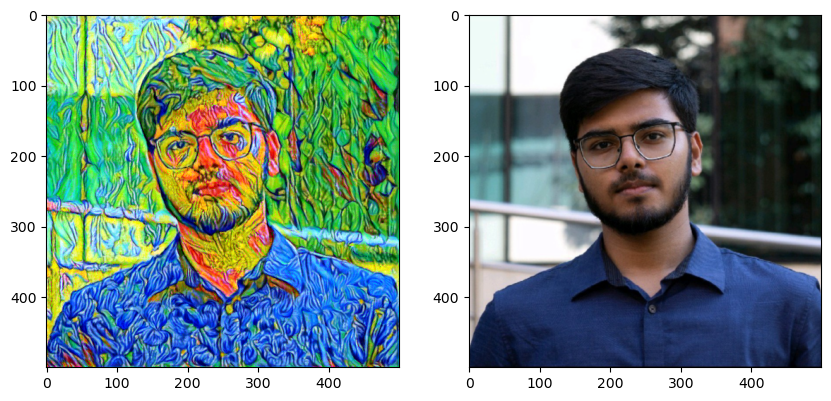

In [75]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)
fig.show()